In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
from matplotlib import pyplot as plt


Figures!

In [2]:
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2022-12-16_15-55-24-478281"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-03-29_14-16-04-931491"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-03-29_14-16-04-931491_UPDATEDMETHOD_April2023"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-10-11_23-47-30-192455"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-10-24_21-00-37-093241"
output_dir = os.path.join(base_dir, "outputs")
outputs_dirs = [os.path.join(output_dir, f"option_{i}") for i in range(6)]

In [3]:
collection_list_options = []

for opt in range(6):
    outputs = outputs_dirs[opt]
    collection_list = []

    # for each arr, store a 2D array in the list
    # axis = 0 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
    # axis = 1 are the years 2016, 2021, 2026, 2031, 2051
    for i,f in enumerate(sorted(glob(outputs + "/*.npy"))):
        """ 
        The shape of each of these arrays is (51,2,2,2,6)
        The index on each axis corresponds to year, black, pov, plus65, smoking state
        And the array element at that location is the weighted count.
        (These are numpy outputs from the simulation)
        """
        arr = np.load(f)
        arr = arr[:,:,:,0,:] # age-restrict 18-64
        arr = arr[:-5] # get the years we are interested in
        arr = arr[:,:,:,:-1] # don't need dead people (smoking state 6)
        arr = arr.transpose((3,1,2,0)) # transpose so we have (smoking states, black, pov, years) as axes
        arr = np.concatenate([ # want to add the smokers together too
            arr[0:4],
            (arr[2] + arr[3])[np.newaxis, :],
            arr[4][np.newaxis, :],
        ], axis=0)
        arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups to be menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
        # add change 2016-2031 column and change from SQ column
        collection_list.append(arr)

    collection_list_options.append(collection_list)

collection_list_options = np.array(collection_list_options)

In [4]:
"""
The axes here are ban option #, output #, smoking state, black, pov, year
with the smoking states being menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
"""
print(collection_list_options.shape)

(6, 125, 6, 2, 2, 46)


## grab BRFSS and NHIS data

In [63]:
# BRFSS data
file = os.path.join("..", "..", "nhis_data", "BRFSSNHIS_Jiaqian.xlsx")

# US population
BRFSS_data = np.concatenate([
    pd.read_excel(file).to_numpy()[5,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[5,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[5,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data,
], axis=1)
BRFSS_x = BRFSS_data[:,0]
BRFSS_y = BRFSS_data[:,1]
BRFSS_e = BRFSS_data[:,3] - BRFSS_data[:,2]
BRFSS_e /= 2

# Black population
BRFSS_data_black = np.concatenate([
    pd.read_excel(file).to_numpy()[10,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[10,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[10,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data_black = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data_black,
], axis=1)
BRFSS_x_black = BRFSS_data_black[:,0]
BRFSS_y_black = BRFSS_data_black[:,1]
BRFSS_e_black = BRFSS_data_black[:,3] - BRFSS_data_black[:,2]
BRFSS_e_black /= 2

# Nonblack population
BRFSS_data_nonblack = np.concatenate([
    pd.read_excel(file).to_numpy()[15,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[15,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[15,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data_nonblack = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data_nonblack,
], axis=1)
BRFSS_x_nonblack = BRFSS_data_nonblack[:,0]
BRFSS_y_nonblack = BRFSS_data_nonblack[:,1]
BRFSS_e_nonblack = BRFSS_data_nonblack[:,3] - BRFSS_data_nonblack[:,2]
BRFSS_e_nonblack /= 2


In [50]:
NHIS_file = os.path.join("../../nhis_data/NHIS_state_Jiaqian_Oct2023.xlsx")

def add_error_column(arr):
    return np.concatenate([
        arr,
        (arr[:,2] - arr[:,1]).reshape((-1,1))/2
    ], axis=1)

NHIS_smoking_prevalence_18_64_all = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_All_18-64").to_numpy()[2::6,3:6])
# print("all")
# print(NHIS_smoking_prevalence_18_64_all)
NHIS_smoking_prevalence_18_64_black = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_NH Black_18-64").to_numpy()[2::6,3:6])
# print("black")
# print(NHIS_smoking_prevalence_18_64_black)
NHIS_smoking_prevalence_18_64_nonblack = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_All other races_18-64").to_numpy()[2::6,3:6])
# print("nonblack")
# print(NHIS_smoking_prevalence_18_64_nonblack )
NHIS_smoking_prevalence_18_64_pov = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_Poverty_18-64").to_numpy()[2::6,3:6])
# print("pov")
print(NHIS_smoking_prevalence_18_64_pov )
NHIS_smoking_prevalence_18_64_nonpov = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_Above FPL_18-64").to_numpy()[2::6,3:6])
# print("nonpov")
# print(NHIS_smoking_prevalence_18_64_nonpov )

NHIS_x = np.array([2016, 2017, 2018, 2019, 2020, 2021])

[[24.0953378050436 22.30439931398652 25.88627629610068 3.58187698211416]
 [21.83177881015995 19.941146262043386 23.722411358276513
  3.7812650962331276]
 [22.1972912 20.22356098 24.17102142 3.9474604400000004]
 [21.8763 19.9503 23.8023 3.8520000000000003]
 [21.914 19.6174 24.2106 4.5931999999999995]
 [19.6017 17.6487 21.5548 3.9060999999999986]]


## Now looking at cigarette smoking over time, status quo scenario, and by demographic groups

[15.1316     14.57004489 13.74055469 13.0834353  12.44640573 11.87745509
 11.40323581 11.02695529 10.72131423 10.41875576 10.20099875 10.02582215
  9.87093963  9.72931336  9.6148494   9.52628086  9.47406545  9.4108696
  9.37384892  9.3249868   9.28381685  9.23748157  9.1987899   9.16963684
  9.11898983  9.09112504  9.04849726  9.00038919  8.96319838  8.94419453
  8.88579205  8.85938939  8.81976092  8.77950495  8.7356554   8.68973386
  8.64389914  8.57909938  8.52823037  8.47667543  8.40545715  8.35980119
  8.31615962  8.25718553  8.19008146  8.13437648]


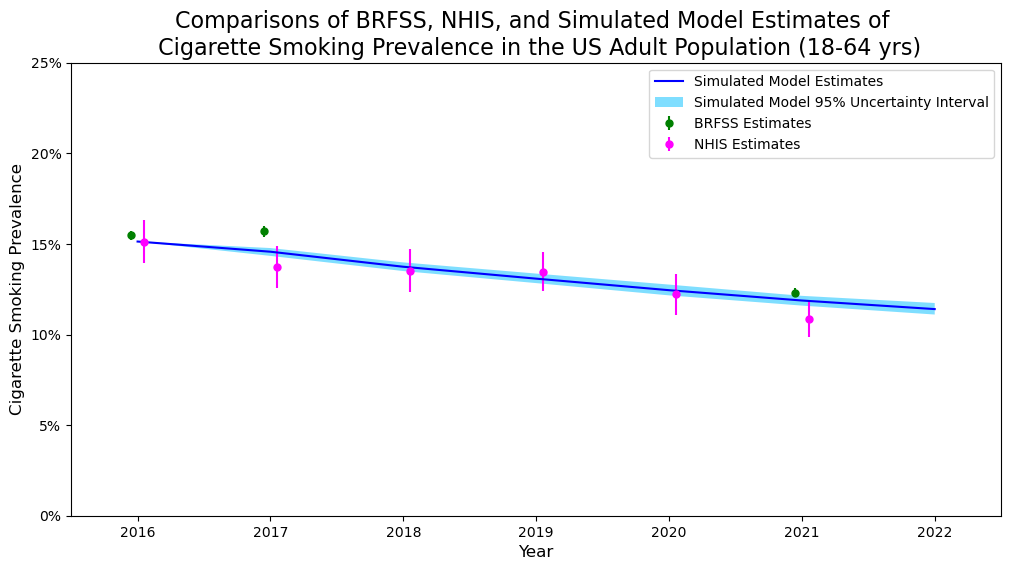

In [80]:
# Cigarette Smokers over time, total population, status quo scenario

year_limit = 7 # limit years to 2022
opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2062)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2,3)) # combine all demographics
# dims:  output #, smoking status, year; shape (125, 6, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:] # only want menthol + nonmenthol
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

print(mean)

ax.plot(x[:year_limit], mean[:year_limit], "blue")
ax.fill_between(x[:year_limit], lower[:year_limit], upper[:year_limit], facecolor='deepskyblue', alpha=0.5)
ax.errorbar(BRFSS_x - 0.05, BRFSS_y, yerr=BRFSS_e, fmt='o', ms=5, color="green")
ax.errorbar(NHIS_x + 0.05, NHIS_smoking_prevalence_18_64_all[:,0], NHIS_smoking_prevalence_18_64_all[:,3], fmt='o', ms=5, color="magenta")

plt.ylim(0,25)
plt.xlim(x[:year_limit][0]-0.5, x[:year_limit][-1]+0.5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cigarette Smoking Prevalence", fontsize=12)
plt.xticks(x[:year_limit][::1], fontsize=10, horizontalalignment='center')
# plt.yticks(np.arange(0,25)[::2], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.title(f"Comparisons of BRFSS, NHIS, and Simulated Model Estimates of \n Cigarette Smoking Prevalence in the US Adult Population (18-64 yrs)", fontsize=16)
plt.legend([ 
    f"Simulated Model Estimates",
    f"Simulated Model 95% Uncertainty Interval",
    f"BRFSS Estimates",
    f"NHIS Estimates",
])

plt.show()





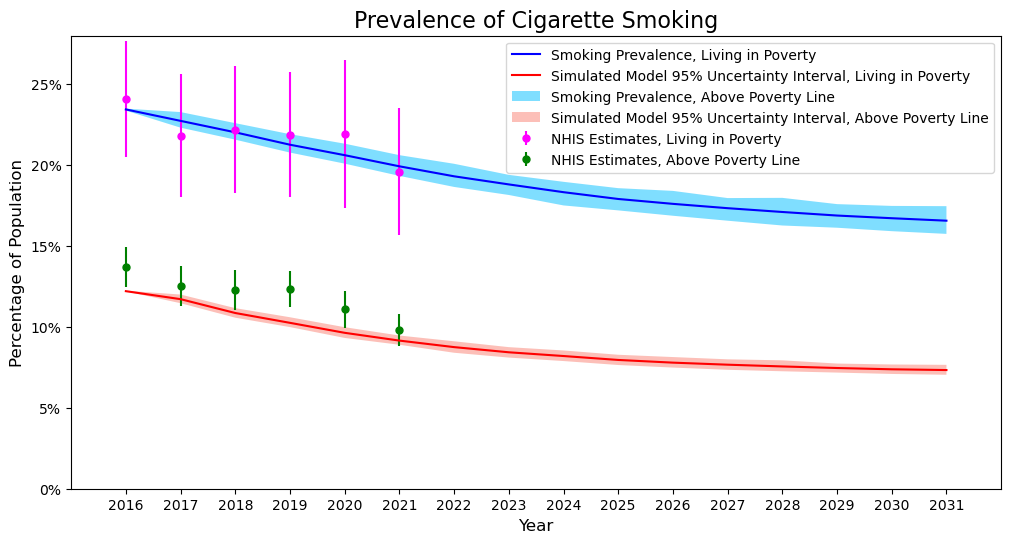

'blah'

In [83]:

# Cigarette Smokers over time, stratified by poverty status, status quo scenario

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2)) # sum over black
# dims:  output #, smoking status, pov, year; shape (125, 6, 2, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:,:] # only want menthol + nonmenthol
to_plot *= 100
to_plot = to_plot[:,:,:16]

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)


# poverty
ax.plot(x, mean[1], "blue", label="Living in poverty")
ax.fill_between(x, lower[1], upper[1], facecolor='deepskyblue', alpha=0.5)

# no poverty
ax.plot(x, mean[0], "red")
ax.fill_between(x, lower[0], upper[0], facecolor='salmon', alpha=0.5)

ax.errorbar(NHIS_x, NHIS_smoking_prevalence_18_64_pov[:,0], NHIS_smoking_prevalence_18_64_pov[:,3], fmt='o', ms=5, color="magenta")
ax.errorbar(NHIS_x, NHIS_smoking_prevalence_18_64_nonpov[:,0], NHIS_smoking_prevalence_18_64_nonpov[:,3], fmt='o', ms=5, color="green")

plt.ylim(5,28)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"Smoking Prevalence, Living in Poverty",
    f"Simulated Model 95% Uncertainty Interval, Living in Poverty",
    f"Smoking Prevalence, Above Poverty Line",
    f"Simulated Model 95% Uncertainty Interval, Above Poverty Line",
    f"NHIS Estimates, Living in Poverty",
    f"NHIS Estimates, Above Poverty Line",
])

plt.show()

"blah"


[[14.68629813 14.20291069 13.34563109 12.67736544 12.0187957  11.44011547
  10.96072918 10.57824204 10.27225369  9.97264434  9.75441546  9.57875823
   9.42827579  9.27588801  9.16322546  9.07975726]
 [18.39603124 17.25274728 16.61249685 16.02706843 15.53656716 15.03653011
  14.5959776  14.27329949 13.96779965 13.64794326 13.43392344 13.26602976
  13.09041583 13.02722264 12.90478785 12.77185204]]


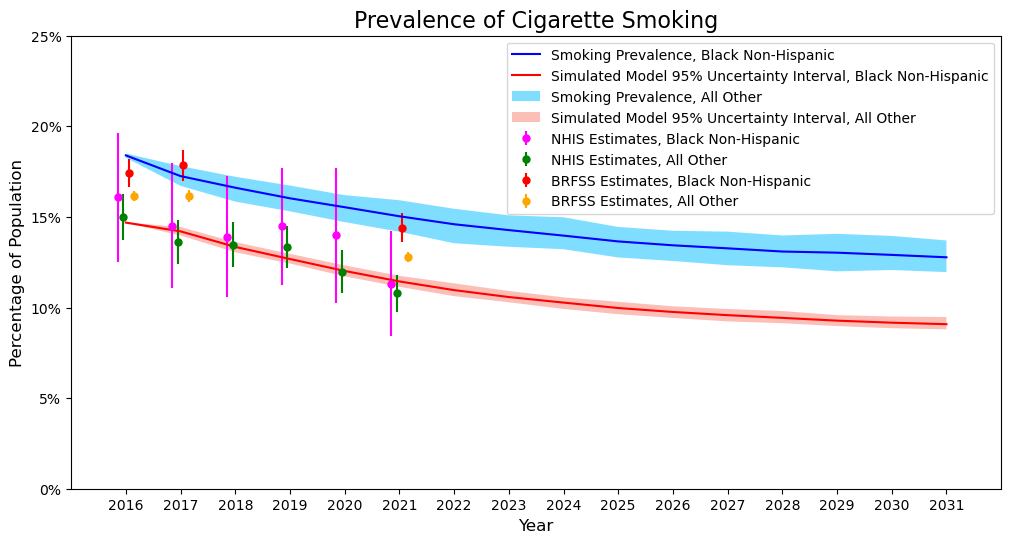

In [84]:

# Cigarette Smokers over time, stratified by race, status quo scenario

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(3)) # sum over pov
# dims:  output #, smoking status, pov, year; shape (125, 6, 2, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:,:] # only want menthol + nonmenthol
to_plot *= 100
to_plot = to_plot[:,:,:16]

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

print(mean)

# black
ax.plot(x, mean[1], "blue")
ax.fill_between(x, lower[1], upper[1], facecolor='deepskyblue', alpha=0.5)

# non black
ax.plot(x, mean[0], "red")
ax.fill_between(x, lower[0], upper[0], facecolor='salmon', alpha=0.5)

ax.errorbar(NHIS_x-0.15, NHIS_smoking_prevalence_18_64_black[:,0], NHIS_smoking_prevalence_18_64_black[:,3], fmt='o', ms=5, color="magenta")
ax.errorbar(NHIS_x-0.05, NHIS_smoking_prevalence_18_64_nonblack[:,0], NHIS_smoking_prevalence_18_64_nonblack[:,3], fmt='o', ms=5, color="green")

ax.errorbar(BRFSS_x_black+0.05, BRFSS_y_black, yerr=BRFSS_e_black, fmt='o', ms=5, color="red")
ax.errorbar(BRFSS_x_nonblack+0.15, BRFSS_y_nonblack, yerr=BRFSS_e_nonblack, fmt='o', ms=5, color="orange")

plt.ylim(5,25)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"Smoking Prevalence, Black Non-Hispanic",
    f"Simulated Model 95% Uncertainty Interval, Black Non-Hispanic",
    f"Smoking Prevalence, All Other",
    f"Simulated Model 95% Uncertainty Interval, All Other",
    f"NHIS Estimates, Black Non-Hispanic",
    f"NHIS Estimates, All Other",
    f"BRFSS Estimates, Black Non-Hispanic",
    f"BRFSS Estimates, All Other",
])

plt.show()

In [10]:

"""
opt = 1
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, 2, :])
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean_SQ, "blue")
ax.fill_between(x, lower_SQ, upper_SQ, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.plot(x, mean, "red")
ax.fill_between(x, lower, upper, facecolor='tomato', alpha=0.5, label='_nolegend_')
ax.axvline(2021, ymin=0.1, ymax=0.9, color='k', linestyle='dashed')

ax.text(2031.1, mean_SQ[-1], f"{np.around(mean_SQ[-1], decimals=1)}%", c='k')
ax.text(2031.1, mean[-1], f"{np.around(mean[-1], decimals=1)}%", c='k')

plt.ylim(5,18)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"Cigarette smoking prevalence, status quo scenario",
    f"Cigarette smoking prevalence, ban option={opt}",
])

plt.show()
"""

'\nopt = 1\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\nto_plot = np.copy(collection_list_options[opt, :, 2, :])\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean_SQ, "blue")\nax.fill_between(x, lower_SQ, upper_SQ, facecolor=\'deepskyblue\', alpha=0.5, label=\'_nolegend_\')\nax.plot(x, mean, "red")\nax.fill_between(x, lower, upper, facecolor=\'tomato\', alpha=0.5, label=\'_nolegend_\')\nax.axvline(2021, ymin=0.1, ymax=0.9, color=\'k\', linestyle=\'dashed\')\n\nax.text(2031.1, mean_SQ[-1], f"{np.around(mean_SQ[-1], decimals=1)}%", c=\'k\')\nax.text(2031.1, mean[-1], f"{np.around(mean[-1], decimals=1)}%", c=\'k\')\n\nplt.ylim(5,18)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Cigarette Sm

In [11]:
# NSDUH Data (2016-2020)

NSDUH_all = np.array([39.17, 40.11, 40.98, 42.04, 43.51])
NSDUH_black = np.array([87.36, 82.75, 86.39, 85.96, 80.42])
NSDUH_pov = np.array([45.39, 47.01, 47.54, 52.64, 52.83])

In [12]:
# Menthol users among all smokers
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_all, c='red')

plt.ylim(35,61)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=(3,4))\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_all, c=\'red\')\n\nplt.ylim(35,61)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Smokers", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estimates of methol prevalence",\

In [13]:

# Menthol users among black smokers
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=4)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_black, c='red')

plt.ylim(75, 95)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Black Non-Hispanic Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=4)[:,:,:,1]\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_black, c=\'red\')\n\nplt.ylim(75, 95)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Black Non-Hispanic Smokers", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estima

In [14]:

# Menthol users among pov smokers

"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=3)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_pov, c='red')

plt.ylim(44, 68)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers Living in Poverty", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=3)[:,:,:,1]\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_pov, c=\'red\')\n\nplt.ylim(44, 68)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Smokers Living in Poverty", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estimates

In [15]:
# Looking at old people just for fun

"""
output_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"

collection_list = []

# for each arr, store a 2D array in the list
# axis = 0 will be the iteration
# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
# axis = 2 will be the years 2016-2031
# axis = 3 will be black
# axis = 4 will be pov
for i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):
    arr = np.load(f)
    # shape at this point is year, black, pov, plus65, smoking_state
    arr = arr[1:16] # get the years we are interested in
    arr = arr[:, :, :, 1, :] # remove people 65 and over
    arr = arr[:, :, :, :-1] # don't need dead people
    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year
    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions
    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes
    arr = np.concatenate([ # want to add the smokers together too
        arr[0:4],
        (arr[2] + arr[3])[np.newaxis, :,:,:],
        arr[4][np.newaxis, :,:,:],
    ], axis=0)
    arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups

    collection_list.append(arr)

SQ_output_arr = np.array(collection_list)
"""

'\noutput_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"\n\ncollection_list = []\n\n# for each arr, store a 2D array in the list\n# axis = 0 will be the iteration\n# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)\n# axis = 2 will be the years 2016-2031\n# axis = 3 will be black\n# axis = 4 will be pov\nfor i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):\n    arr = np.load(f)\n    # shape at this point is year, black, pov, plus65, smoking_state\n    arr = arr[1:16] # get the years we are interested in\n    arr = arr[:, :, :, 1, :] # remove people 65 and over\n    arr = arr[:, :, :, :-1] # don\'t need dead people\n    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year\n    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions\n    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes\n

In [16]:

# Cigarette Smokers over time
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2017,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
print(mean[-1])
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
# ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5)

plt.ylim(5,15)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking Among 65+ Year-Olds", fontsize=16)
# plt.legend([ 
#     f"Cigarette smoking prevalence, status quo scenario",
#     f"95% uncertainty interval",
# ])
"""


'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2017,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,2:,:,:,:]\nto_plot = np.sum(to_plot, axis=(3,4))\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nprint(mean[-1])\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\n# ax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label=\'_nolegend_\')\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5)\n\nplt.ylim(5,15)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Cigarette Smoking Among 65+ Year-Olds", fontsize=16)\n# plt.legend([ \n#     f"Cigarette smoking prevalence, statu

### Now all smoking groups

(6, 16)
(6, 16)
(6, 16)


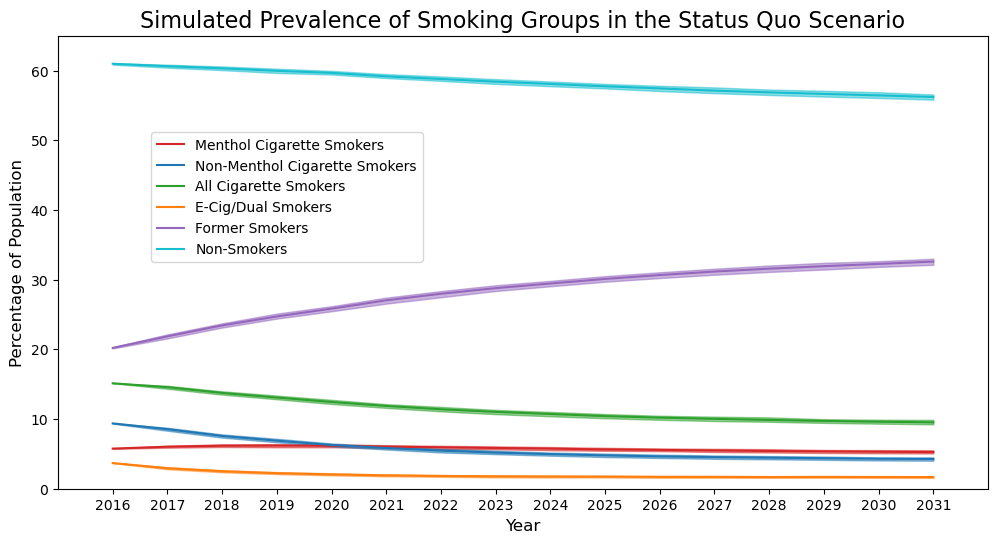

In [22]:

# Smoking groups over time, total population, status quo scenario
# with the smoking states being menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:cyan',]

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
to_plot = to_plot[:,:,:,:,:16] # first 15 years 
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2,3)) # combine all demographics
# dims:  output #, smoking status, year; shape (125, 6, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :] # change from absolute counts to proportion of total
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)
print(mean.shape)
print(lower.shape)
print(upper.shape)

ax.plot(x, mean[0], mycolors[0])
ax.fill_between(x, lower[0], upper[0], color=mycolors[0], alpha=0.5, label='_nolegend_')
ax.plot(x, mean[1], mycolors[1])
ax.fill_between(x, lower[1], upper[1], color=mycolors[1], alpha=0.5, label='_nolegend_')
ax.plot(x, mean[2], mycolors[2])
ax.fill_between(x, lower[2], upper[2], color=mycolors[2], alpha=0.5, label='_nolegend_')
ax.plot(x, mean[3], mycolors[3])
ax.fill_between(x, lower[3], upper[3], color=mycolors[3], alpha=0.5, label='_nolegend_')
ax.plot(x, mean[4], mycolors[4])
ax.fill_between(x, lower[4], upper[4], color=mycolors[4], alpha=0.5, label='_nolegend_')
ax.plot(x, mean[5], mycolors[5])
ax.fill_between(x, lower[5], upper[5], color=mycolors[5], alpha=0.5, label='_nolegend_')

plt.ylim(0,65)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
# y_tick_nums = np.arange(0,61,10)
# y_tick_labels = [str(x) + "%" for x in y_tick_nums]
# plt.yticks(y_tick_nums, y_tick_labels)
plt.title(f"Simulated Prevalence of Smoking Groups in the Status Quo Scenario", fontsize=16)
plt.legend(loc=(0.1,0.5) , labels=[ 
    f"Menthol Cigarette Smokers",
    f"Non-Menthol Cigarette Smokers",
    f"All Cigarette Smokers",
    f"E-Cig/Dual Smokers",
    f"Former Smokers",
    f"Non-Smokers",
])

plt.show()